In [1]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

2023-05-19 13:16:02.602208: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 13:16:02.604673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 13:16:02.659520: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 13:16:02.660141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 13:16:03.422357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
# # Primero, bajamos los datos de entrenamiento
# keras.utils.get_file(fname="simpsons_train.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# # Descomprimimos el archivo
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# # Hacemos lo mismo con los datos de test
# keras.utils.get_file(fname="simpsons_test.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
# !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [24]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.85
        if(logs.get('val_accuracy')> accuracy):
            print("\nAlcanzado el {}% de precisión, se cancela el entrenamiento!!".format(accuracy))
            self.model.stop_training = True

In [25]:
callback = myCallback()

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [8]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [9]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

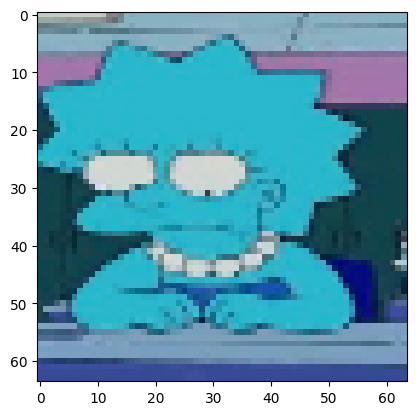

In [10]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro


Prueba batchNormalize


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [12]:
X_scaled = X / 255.0
y = y.astype('int')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [14]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  BatchNormalization(),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(2, 2),
  Conv2D(128, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(2, 2),
  Flatten(),
  Dropout(0.2),
  Dense(512, activation='relu'),
  Dense(18, activation='softmax')
])

In [16]:
#Se compila el modelo, se especifica la función de pérdida categórica entrecruzada, el optimizador Adam y la métrica de precisión.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
y_train = to_categorical(y_train, num_classes=18)
y_valid = to_categorical(y_valid, num_classes=18)


In [26]:
history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    callbacks=callback)

Epoch 1/40
475/475 - 28s - loss: 0.0915 - accuracy: 0.9720 - val_loss: 1.4387 - val_accuracy: 0.7655 - 28s/epoch - 58ms/step
Epoch 2/40
475/475 - 28s - loss: 0.0734 - accuracy: 0.9768 - val_loss: 1.6382 - val_accuracy: 0.7697 - 28s/epoch - 60ms/step
Epoch 3/40
475/475 - 29s - loss: 0.0830 - accuracy: 0.9756 - val_loss: 1.0232 - val_accuracy: 0.8223 - 29s/epoch - 61ms/step
Epoch 4/40
475/475 - 30s - loss: 0.0877 - accuracy: 0.9768 - val_loss: 1.4187 - val_accuracy: 0.7997 - 30s/epoch - 62ms/step
Epoch 5/40
475/475 - 31s - loss: 0.0720 - accuracy: 0.9793 - val_loss: 1.0215 - val_accuracy: 0.8273 - 31s/epoch - 66ms/step
Epoch 6/40
475/475 - 29s - loss: 0.0529 - accuracy: 0.9858 - val_loss: 1.1482 - val_accuracy: 0.8394 - 29s/epoch - 62ms/step
Epoch 7/40
475/475 - 30s - loss: 0.0665 - accuracy: 0.9806 - val_loss: 1.2827 - val_accuracy: 0.8286 - 30s/epoch - 63ms/step
Epoch 8/40
475/475 - 28s - loss: 0.0611 - accuracy: 0.9836 - val_loss: 1.1248 - val_accuracy: 0.8134 - 28s/epoch - 59ms/step


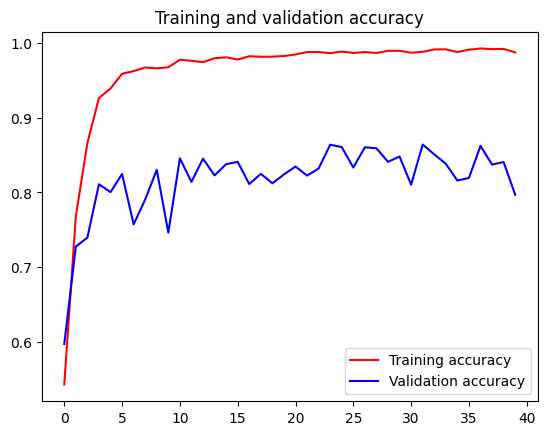

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Prueba

El modelo  tiene un total de 15 capas:

3 capas Conv2D (convolucionales).
3 capas BatchNormalization (normalización por lotes).
3 capas MaxPooling2D (reducción de dimensionalidad).
1 capa Flatten.
1 capa Dropout (regularización).
4 capas Dense (completamente conectadas).

In [ ]:
model = Sequential([

  Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Capa de convolución con 32 filtros de tamaño 3x3 y función de activación ReLU
  BatchNormalization(),  # Capa de normalización por lotes
  MaxPooling2D(2, 2),  # Capa de reducción de dimensionalidad mediante el máximo pooling

  Conv2D(64, (3, 3), activation='relu'),  # Otra capa de convolución con 64 filtros de tamaño 3x3 y función de activación ReLU
  BatchNormalization(),  # Capa de normalización por lotes
  MaxPooling2D(2, 2),  # Capa de reducción de dimensionalidad mediante el máximo pooling

  Conv2D(128, (3, 3), activation='relu'),  # Otra capa de convolución con 128 filtros de tamaño 3x3 y función de activación ReLU
  BatchNormalization(),  # Capa de normalización por lotes
  MaxPooling2D(2, 2),  # Capa de reducción de dimensionalidad mediante el máximo pooling

  Flatten(),  # Capa de aplanamiento de la salida para poder conectarla a capas densas
  Dropout(0.2),  # Capa de dropout para regularizar la red y prevenir el sobreajuste

  Dense(512, activation='relu'),  # Capa densa completamente conectada con 512 neuronas y función de activación ReLU
  Dense(256, activation='relu'),  # Otra capa densa con 256 neuronas y función de activación ReLU
  Dense(128, activation='relu'),  # Otra capa densa con 128 neuronas y función de activación ReLU

  Dense(18, activation='softmax'),  # Capa de salida con 18 neuronas (una para cada clase) y función de activación softmax

])

#Se compila el modelo, se especifica la función de pérdida categórica entrecruzada, el optimizador Adam y la métrica de precisión.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/20
475/475 - 28s - loss: 0.0498 - accuracy: 0.9883 - val_loss: 1.2841 - val_accuracy: 0.8386 - 28s/epoch - 59ms/step
Epoch 2/20
475/475 - 29s - loss: 0.0462 - accuracy: 0.9889 - val_loss: 1.1840 - val_accuracy: 0.8539 - 29s/epoch - 60ms/step
Epoch 3/20
475/475 - 29s - loss: 0.0297 - accuracy: 0.9926 - val_loss: 1.2962 - val_accuracy: 0.8323 - 29s/epoch - 62ms/step
Epoch 4/20
475/475 - 30s - loss: 0.0542 - accuracy: 0.9878 - val_loss: 1.8722 - val_accuracy: 0.7757 - 30s/epoch - 63ms/step
Epoch 5/20
475/475 - 31s - loss: 0.0499 - accuracy: 0.9878 - val_loss: 1.8950 - val_accuracy: 0.7641 - 31s/epoch - 64ms/step
Epoch 6/20
475/475 - 29s - loss: 0.0415 - accuracy: 0.9896 - val_loss: 1.1936 - val_accuracy: 0.8531 - 29s/epoch - 62ms/step
Epoch 7/20
475/475 - 29s - loss: 0.0422 - accuracy: 0.9898 - val_loss: 1.4977 - val_accuracy: 0.8347 - 29s/epoch - 60ms/step
Epoch 7: early stopping


Prueba capa convolucional.

In [ ]:
# La primera capa convolucional. Aplicamos 32 filtros de tamaño 3x3 a la imagen de entrada con una función de activación ReLU. Las imágenes de entrada son de 64x64 píxeles con 3 canales de color (RGB).
#Después de cada capa convolucional, aplicamos una capa de max pooling para reducir las dimensiones espaciales de las características extraídas. Esta capa realiza un muestreo máximo en ventanas de tamaño 2x2.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.2), #Esta capa aplica regularización, lo que ayuda a prevenir el sobreajuste
    Dense(512, activation='relu'), #Capa completamente conectada con 512 neuronas y una función de activación ReLU.
    Dense(18, activation='softmax') #Capa de salida de 18 neuronas, una para cada clase de salida. La función de activación softmax la empleamos para obtener probabilidades de clasificación para cada clase.
])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 128)       

*Ejercicio*  Prueba fully connected. 

In [ ]:
#definicion de la arquitectura del modelo secuencial. 
#Comenzamos con una capa convolucional con 32 filtros de tamaño (3, 3) y función de activación ReLU, seguida de una capa de pooling con tamaño de ventana (2, 2). 
#Luego agreamos dos capas convolucionales más con más filtros y capas de pooling correspondientes. 
#A continuación, se aplanan los mapas de características resultantes y se agrega una capa de dropout para evitar el sobreajuste. 
#Luego se agregan dos capas densamente conectadas, con la última capa utilizando una función de activación softmax para la clasificación de las 18 clases
# Por ultimo el resumen del modelo, que incluye información. 



model = Sequential()
#model.add(Conv2D(32, (3, 3), activation='relu', ))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(18, activation='softmax'))

model.summary()


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()